In [23]:
from datetime import datetime
import pandas as pd
from geopy.distance import distance
import numpy as np
import random

import pymongo
from pymongo import MongoClient



from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from sklearn.model_selection import cross_validate




import pymongo
from pymongo import MongoClient

import matplotlib.pyplot as plt

plt.style.use("ggplot")

%matplotlib inline

In [24]:
client = MongoClient('localhost', 27017)

db = client['avl_pipeline_test']

trip_coll = db['clean_trips']
chnk_coll = db['chunk_info']

In [25]:
trip_coll.find_one()

{'_id': ObjectId('5ae4dcb33ad39e1721401dad'),
 'HEADING': '82.0',
 'LATITUDE': '37.78693',
 'LONGITUDE': '-122.4565',
 'PREDICTABLE': '1',
 'REPORT_TIME': '10/28/2016 00:27:57',
 'REV': '1526',
 'SPEED': '0.0',
 'TRAIN_ASSIGNMENT': '3305',
 'VEHICLE_TAG': '5419',
 'minutes_noon_sqr': 480249,
 'sched_time_diff_seconds': 123,
 'service_id': 1,
 'time_stamp': 1477639677.0,
 'trip_id': 7253717,
 'trip_id_iso': '7253717_2016-10-28_JRMFT',
 'trip_start': 1,
 'chunk_2': '1',
 'chunk_6': '1',
 'chunk_12': '1'}

In [26]:
six_cnk_info = chnk_coll.find_one({'number_chunks':6})

In [27]:
all_trips = trip_coll.distinct('trip_id_iso')
# # Testing
# all_trips = all_trips[33:40]

In [29]:
trip_list = []

for trip_id in all_trips:
    
    trip_data = {}
    
    breakin = 0

    
    
    search = {
                'trip_id_iso': trip_id,
                'trip_start': 1
            }
    
    trip_start = trip_coll.find_one(search)
    
    if not trip_start:
        continue
    
 


    for chnk_seq, chnk_data in six_cnk_info['chunks'].items():
        
        if chnk_seq in ['2','3']:
        
            search = {
                'trip_id_iso': trip_id,
                'chunk_6': chnk_seq
            }

            chnk_str = '_chnk_' + chnk_seq

            chnk_cursor = trip_coll.find(search)
            
            if chnk_cursor.count() == 0:
                breakin += 1
                break

            chnk_df = pd.DataFrame(list(chnk_cursor))

            min_ts = chnk_df['time_stamp'].min()
            max_ts = chnk_df['time_stamp'].max()
            chnk_secs = max_ts - min_ts
            
            if chnk_secs > 2500:
                breakin += 1
                break
    
  
            trip_data['seconds' + chnk_str ] = chnk_secs

            min_dt = datetime.fromtimestamp(min_ts)
            mfn_sq = (((min_dt.hour * 60) + min_dt.minute) - 720)**2

            mfn_abs = abs(((min_dt.hour * 60) + min_dt.minute) - 720)
        
            trip_data['mfn_sq' + chnk_str] = mfn_sq
            trip_data['mfn_abs' + chnk_str] = mfn_abs
            
            avg_spd = chnk_df['SPEED'].astype('float').mean()

            trip_data['avg_speed' + chnk_str] = avg_spd
    
    
    
    
    first_trip_ts = trip_start['time_stamp']
    
    before_search = {
        'time_stamp': {'$lt': first_trip_ts},
        'trip_start': 1
    }
    
    most_recent = list(trip_coll.find(before_search).sort('time_stamp', pymongo.DESCENDING).limit(1))
    
    if not most_recent:
        continue
        
    most_recent = most_recent[0]
    
    prior_ts = most_recent['time_stamp']
    prior_id = most_recent['trip_id_iso']
    
    start_diff = first_trip_ts - prior_ts
    
    if start_diff > 1800:
        continue
        
        
    # Get prior chunk data
    for chnk_seq, chnk_data in six_cnk_info['chunks'].items():

        if chnk_seq in ['2','3']:

            search = {
                'trip_id_iso': prior_id,
                'chunk_6': chnk_seq
            }

            chnk_str = 'prior_chnk_' + chnk_seq

            chnk_cursor = trip_coll.find(search)

            if chnk_cursor.count() == 0:
                breakin += 1
                break

            chnk_df = pd.DataFrame(list(chnk_cursor))

            min_ts = chnk_df['time_stamp'].min()
            max_ts = chnk_df['time_stamp'].max()
            chnk_secs = max_ts - min_ts

            if chnk_secs > 2500:
                breakin += 1
                break


            trip_data['seconds' + chnk_str ] = chnk_secs

            min_dt = datetime.fromtimestamp(min_ts)
            mfn_sq = (((min_dt.hour * 60) + min_dt.minute) - 720)**2

            mfn_abs = abs(((min_dt.hour * 60) + min_dt.minute) - 720)

            trip_data['mfn_sq' + chnk_str] = mfn_sq
            trip_data['mfn_abs' + chnk_str] = mfn_abs

            avg_spd = chnk_df['SPEED'].astype('float').mean()

            trip_data['avg_speed' + chnk_str] = avg_spd
        
    
    if breakin == 0:
    
        trip_list.append(trip_data)

In [30]:
chnky_df = pd.DataFrame(trip_list)

In [32]:
chnky_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 16 columns):
avg_speed_chnk_2         1060 non-null float64
avg_speed_chnk_3         1060 non-null float64
avg_speedprior_chnk_2    1060 non-null float64
avg_speedprior_chnk_3    1060 non-null float64
mfn_abs_chnk_2           1060 non-null int64
mfn_abs_chnk_3           1060 non-null int64
mfn_absprior_chnk_2      1060 non-null int64
mfn_absprior_chnk_3      1060 non-null int64
mfn_sq_chnk_2            1060 non-null int64
mfn_sq_chnk_3            1060 non-null int64
mfn_sqprior_chnk_2       1060 non-null int64
mfn_sqprior_chnk_3       1060 non-null int64
seconds_chnk_2           1060 non-null float64
seconds_chnk_3           1060 non-null float64
secondsprior_chnk_2      1060 non-null float64
secondsprior_chnk_3      1060 non-null float64
dtypes: float64(8), int64(8)
memory usage: 132.6 KB


In [35]:
y = chnky_df['seconds_chnk_3'].values
y = y.reshape(-1,1)

In [36]:
X = chnky_df[['seconds_chnk_2', 'mfn_abs_chnk_2', 'secondsprior_chnk_3']].values
# X = X.reshape(-1,1)

In [37]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

scaler_y = StandardScaler()
y_norm = scaler_y.fit_transform(y)

# X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

# X_norm = X
# y_norm = y

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

In [38]:
# fit with statsmodels
model1 = sm.OLS(y_train,X_train)
results = model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     17.94
Date:                Fri, 04 May 2018   Prob (F-statistic):           2.85e-11
Time:                        15:35:08   Log-Likelihood:                -1128.0
No. Observations:                 795   AIC:                             2262.
Df Residuals:                     792   BIC:                             2276.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0639      0.035      1.809      0.071      -0.005       0.133
x2            -0.1739      0.037     -4.727      0.000      -0.246      -0.102
x3             0.1294      0.036      3.560      0.000       0.058       0.201
==============================================================================
Omnibus:                      352.040   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6951.285
Skew:                           1.507   Prob(JB):                         0.00
Kurtosis:                      17.169   Cond. No.                         1.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
regr = RandomForestRegressor(n_estimators=50)

crossed = cross_validate(regr, X_norm, y_norm.flatten(), cv=20, 
                         scoring=['neg_mean_squared_error','r2'], return_train_score=False)

rmse_norm = (abs(crossed['test_neg_mean_squared_error'].mean()))**.5
r2 = crossed['test_neg_mean_squared_error'].mean()

print ("R-squared: ", r2)
print ('RMSE: ', scaler_y.inverse_transform([rmse_norm])[0])

R-squared:  -1.0037300432420457
RMSE:  539.5096766075443


In [40]:
x = chnky_df['secondsprior_chnk_3'].values
y = chnky_df['seconds_chnk_3'].values

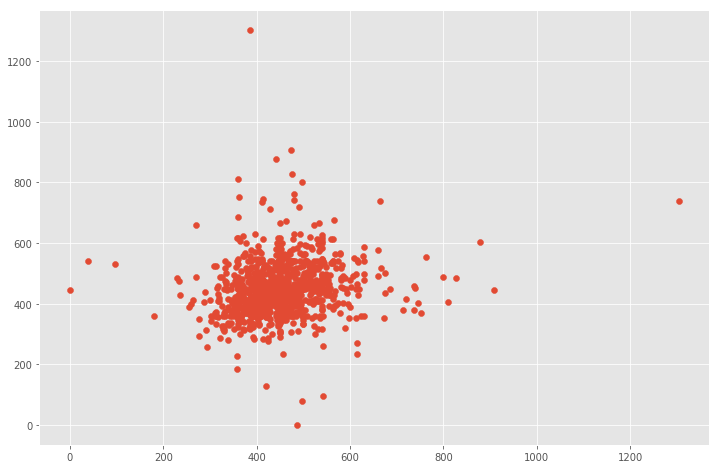

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y);